In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import os

In [2]:
torch.manual_seed(99)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Resize(64), 
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10("./cifar10", download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

Files already downloaded and verified


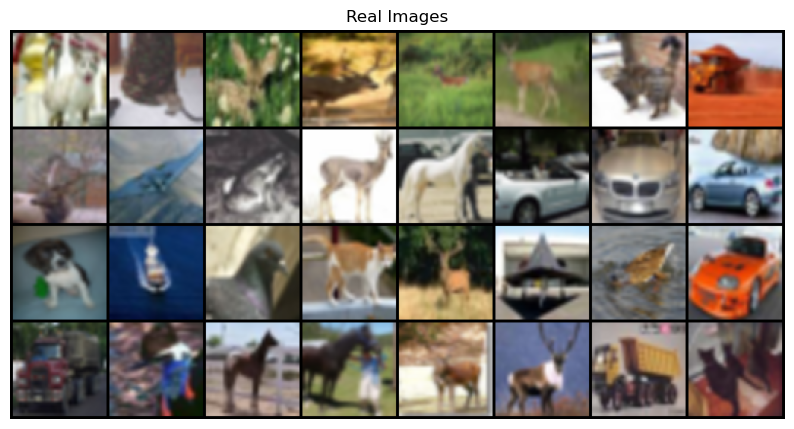

In [5]:
real_image_batch = next(iter(data_loader))
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=1024, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

In [8]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 0.0, 0.02)

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [10]:
if not os.path.exists('Results/DCGAN_FAKE'):
    os.makedirs('Results/DCGAN_FAKE')
if not os.path.exists('Results/DCGAN_REAL'):
    os.makedirs('Results/DCGAN_REAL')

In [11]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.to(device)

/home/tpittal/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tpittal/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [13]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [14]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [15]:
gen_loss_arr = []
disc_loss_arr = []
fake_image = []
real_image = []
FID_arr = []

from tqdm import tqdm

def train(generator, discriminator, dataloader, epochs):
    optim_generator = optim.Adam(generator.parameters(), lr=5e-5, betas=(0.5, 0.999))
    optim_discriminator = optim.Adam(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.999))
    loss_func = nn.BCELoss()
    
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        print(f"Epoch [{epoch+1}/{epochs}]")
        
        batch_gen_loss = []
        batch_disc_loss = []
        real_images = None
        fake_images = None
        
        # Wrap dataloader with tqdm
        with tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]") as progress_bar:
            for i, real_images in enumerate(progress_bar):
                real_images = real_images[0].to(device)
                batch_size = real_images.size(0)
                
                # Train Discriminator
                noise = torch.randn(batch_size, 100, 1, 1).to(device)
                fake_images = generator(noise)
                
                real_disc = discriminator(real_images).reshape(-1)
                real_disc_loss = loss_func(real_disc, torch.ones_like(real_disc))
                fake_disc = discriminator(fake_images.detach()).reshape(-1)
                fake_disc_loss = loss_func(fake_disc, torch.zeros_like(fake_disc))
                loss_disc = (real_disc_loss + fake_disc_loss) / 2
                discriminator.zero_grad()
                loss_disc.backward()
                optim_discriminator.step()
                batch_disc_loss.append(loss_disc.item())
                
                # Train Generator
                output = discriminator(fake_images).reshape(-1)
                loss_gen = loss_func(output, torch.ones_like(output))
                generator.zero_grad()
                loss_gen.backward()
                optim_generator.step()
                batch_gen_loss.append(loss_gen.item())
                
                # Update tqdm description
                progress_bar.set_postfix(
                    Discriminator_Loss=f"{loss_disc.item():.4f}",
                    Generator_Loss=f"{loss_gen.item():.4f}"
                )
        
        # Save images and log epoch-level stats
        with torch.no_grad():
            noise = torch.randn(32, 100, 1, 1, device=device)
            fake_images = generator(noise)
            fakeimg_grid = torchvision.utils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True)
            real_images_grid = torchvision.utils.make_grid(real_images.detach().cpu(), padding=2, normalize=True)
            fake_image.append(fakeimg_grid)
            real_image.append(real_images_grid)
            utils.save_image(fakeimg_grid, f'./Results/DCGAN_FAKE/DCGAN_epoch_{epoch:03d}.png', normalize=True)
            utils.save_image(real_images_grid, f'./Results/DCGAN_REAL/DCGAN_epoch_{epoch:03d}.png', normalize=True)
        
        gen_loss_arr.append(np.mean(batch_gen_loss))
        disc_loss_arr.append(np.mean(batch_disc_loss))

        # Calculate FID
        fretchet_dist = calculate_fretchet(real_images, fake_images, inception_model)
        FID_arr.append(fretchet_dist)
        print(f"FID value at epoch {epoch+1}/{epochs} is {fretchet_dist:.4f}")


In [16]:
train(generator, discriminator, data_loader, 50)

Epoch [1/50]


Epoch [1/50]: 100%|██████████| 1562/1562 [00:30<00:00, 51.93it/s, Discriminator_Loss=0.2819, Generator_Loss=2.1858]


FID value at epoch 1/50 is 350.0820
Epoch [2/50]


Epoch [2/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.31it/s, Discriminator_Loss=0.3983, Generator_Loss=1.3880]


FID value at epoch 2/50 is 290.0357
Epoch [3/50]


Epoch [3/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.23it/s, Discriminator_Loss=0.5348, Generator_Loss=0.9594]


FID value at epoch 3/50 is 252.5424
Epoch [4/50]


Epoch [4/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.42it/s, Discriminator_Loss=0.4092, Generator_Loss=1.2392]


FID value at epoch 4/50 is 252.6621
Epoch [5/50]


Epoch [5/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.22it/s, Discriminator_Loss=0.4344, Generator_Loss=1.0942]


FID value at epoch 5/50 is 250.2118
Epoch [6/50]


Epoch [6/50]: 100%|██████████| 1562/1562 [00:24<00:00, 63.07it/s, Discriminator_Loss=0.2551, Generator_Loss=1.8999]


FID value at epoch 6/50 is 240.3413
Epoch [7/50]


Epoch [7/50]: 100%|██████████| 1562/1562 [00:30<00:00, 51.86it/s, Discriminator_Loss=0.3638, Generator_Loss=1.2280]


FID value at epoch 7/50 is 228.4980
Epoch [8/50]


Epoch [8/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.10it/s, Discriminator_Loss=0.3102, Generator_Loss=1.7031]


FID value at epoch 8/50 is 234.0475
Epoch [9/50]


Epoch [9/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.12it/s, Discriminator_Loss=0.2748, Generator_Loss=2.1443]


FID value at epoch 9/50 is 244.2406
Epoch [10/50]


Epoch [10/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.30it/s, Discriminator_Loss=0.2705, Generator_Loss=2.0779]


FID value at epoch 10/50 is 240.1882
Epoch [11/50]


Epoch [11/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.23it/s, Discriminator_Loss=0.2289, Generator_Loss=1.7969]


FID value at epoch 11/50 is 238.3137
Epoch [12/50]


Epoch [12/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.22it/s, Discriminator_Loss=0.2697, Generator_Loss=3.3743]


FID value at epoch 12/50 is 241.4748
Epoch [13/50]


Epoch [13/50]: 100%|██████████| 1562/1562 [00:23<00:00, 66.39it/s, Discriminator_Loss=0.7261, Generator_Loss=5.4850] 


FID value at epoch 13/50 is 233.0631
Epoch [14/50]


Epoch [14/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.20it/s, Discriminator_Loss=0.2250, Generator_Loss=2.9651]


FID value at epoch 14/50 is 242.1664
Epoch [15/50]


Epoch [15/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.15it/s, Discriminator_Loss=0.2359, Generator_Loss=3.4368] 


FID value at epoch 15/50 is 252.0549
Epoch [16/50]


Epoch [16/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.31it/s, Discriminator_Loss=0.1812, Generator_Loss=2.6091]


FID value at epoch 16/50 is 232.7451
Epoch [17/50]


Epoch [17/50]: 100%|██████████| 1562/1562 [00:30<00:00, 51.98it/s, Discriminator_Loss=0.4121, Generator_Loss=1.0120]


FID value at epoch 17/50 is 229.9884
Epoch [18/50]


Epoch [18/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.18it/s, Discriminator_Loss=0.1740, Generator_Loss=1.8939]


FID value at epoch 18/50 is 257.5849
Epoch [19/50]


Epoch [19/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.11it/s, Discriminator_Loss=0.1979, Generator_Loss=3.1987]


FID value at epoch 19/50 is 252.3451
Epoch [20/50]


Epoch [20/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.26it/s, Discriminator_Loss=0.1392, Generator_Loss=2.5457] 


FID value at epoch 20/50 is 257.2836
Epoch [21/50]


Epoch [21/50]: 100%|██████████| 1562/1562 [00:27<00:00, 57.71it/s, Discriminator_Loss=0.1229, Generator_Loss=3.0297]


FID value at epoch 21/50 is 217.6578
Epoch [22/50]


Epoch [22/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.30it/s, Discriminator_Loss=0.1484, Generator_Loss=2.9539]


FID value at epoch 22/50 is 246.6928
Epoch [23/50]


Epoch [23/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.21it/s, Discriminator_Loss=0.1337, Generator_Loss=2.2468]


FID value at epoch 23/50 is 227.7334
Epoch [24/50]


Epoch [24/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.33it/s, Discriminator_Loss=0.1177, Generator_Loss=2.6464] 


FID value at epoch 24/50 is 228.8355
Epoch [25/50]


Epoch [25/50]: 100%|██████████| 1562/1562 [00:30<00:00, 52.02it/s, Discriminator_Loss=0.0689, Generator_Loss=3.3350]


FID value at epoch 25/50 is 227.3837
Epoch [26/50]


Epoch [26/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.48it/s, Discriminator_Loss=0.2706, Generator_Loss=2.0291]


FID value at epoch 26/50 is 241.8304
Epoch [27/50]


Epoch [27/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.31it/s, Discriminator_Loss=0.1039, Generator_Loss=3.5068]


FID value at epoch 27/50 is 236.1414
Epoch [28/50]


Epoch [28/50]: 100%|██████████| 1562/1562 [00:23<00:00, 67.66it/s, Discriminator_Loss=1.1877, Generator_Loss=7.8237] 


FID value at epoch 28/50 is 244.6101
Epoch [29/50]


Epoch [29/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.24it/s, Discriminator_Loss=0.0764, Generator_Loss=3.2988]


FID value at epoch 29/50 is 244.8031
Epoch [30/50]


Epoch [30/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.38it/s, Discriminator_Loss=0.2369, Generator_Loss=6.3060]


FID value at epoch 30/50 is 261.1679
Epoch [31/50]


Epoch [31/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.27it/s, Discriminator_Loss=0.1233, Generator_Loss=3.7163]


FID value at epoch 31/50 is 245.5199
Epoch [32/50]


Epoch [32/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.38it/s, Discriminator_Loss=0.0883, Generator_Loss=3.7969]


FID value at epoch 32/50 is 256.5440
Epoch [33/50]


Epoch [33/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.08it/s, Discriminator_Loss=0.2728, Generator_Loss=4.1049]


FID value at epoch 33/50 is 244.3905
Epoch [34/50]


Epoch [34/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.33it/s, Discriminator_Loss=0.1008, Generator_Loss=3.2604]


FID value at epoch 34/50 is 237.5943
Epoch [35/50]


Epoch [35/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.39it/s, Discriminator_Loss=0.4068, Generator_Loss=2.0161]


FID value at epoch 35/50 is 244.5562
Epoch [36/50]


Epoch [36/50]: 100%|██████████| 1562/1562 [00:29<00:00, 53.00it/s, Discriminator_Loss=0.0730, Generator_Loss=3.7857]


FID value at epoch 36/50 is 239.7963
Epoch [37/50]


Epoch [37/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.22it/s, Discriminator_Loss=0.0858, Generator_Loss=3.9944]


FID value at epoch 37/50 is 242.7670
Epoch [38/50]


Epoch [38/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.32it/s, Discriminator_Loss=0.1364, Generator_Loss=2.5659]


FID value at epoch 38/50 is 237.7731
Epoch [39/50]


Epoch [39/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.40it/s, Discriminator_Loss=0.1796, Generator_Loss=3.0459]


FID value at epoch 39/50 is 223.6638
Epoch [40/50]


Epoch [40/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.44it/s, Discriminator_Loss=0.9945, Generator_Loss=4.6003]


FID value at epoch 40/50 is 243.9872
Epoch [41/50]


Epoch [41/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.35it/s, Discriminator_Loss=0.0617, Generator_Loss=3.8111]


FID value at epoch 41/50 is 235.4545
Epoch [42/50]


Epoch [42/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.30it/s, Discriminator_Loss=0.4426, Generator_Loss=5.9971]


FID value at epoch 42/50 is 229.0636
Epoch [43/50]


Epoch [43/50]: 100%|██████████| 1562/1562 [00:23<00:00, 66.81it/s, Discriminator_Loss=0.4166, Generator_Loss=1.6085]


FID value at epoch 43/50 is 237.6896
Epoch [44/50]


Epoch [44/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.38it/s, Discriminator_Loss=0.0771, Generator_Loss=4.8297]


FID value at epoch 44/50 is 247.9424
Epoch [45/50]


Epoch [45/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.19it/s, Discriminator_Loss=0.0309, Generator_Loss=4.2083] 


FID value at epoch 45/50 is 239.3912
Epoch [46/50]


Epoch [46/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.13it/s, Discriminator_Loss=0.0407, Generator_Loss=4.0711] 


FID value at epoch 46/50 is 258.2192
Epoch [47/50]


Epoch [47/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.16it/s, Discriminator_Loss=0.2961, Generator_Loss=1.7750]


FID value at epoch 47/50 is 224.8814
Epoch [48/50]


Epoch [48/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.36it/s, Discriminator_Loss=0.0531, Generator_Loss=3.9646] 


FID value at epoch 48/50 is 248.0696
Epoch [49/50]


Epoch [49/50]: 100%|██████████| 1562/1562 [00:29<00:00, 52.17it/s, Discriminator_Loss=0.0400, Generator_Loss=4.0665]


FID value at epoch 49/50 is 242.7840
Epoch [50/50]


Epoch [50/50]: 100%|██████████| 1562/1562 [00:29<00:00, 53.67it/s, Discriminator_Loss=0.0250, Generator_Loss=4.1231]


FID value at epoch 50/50 is 227.5209


In [17]:
if not os.path.exists('Results/FID'):
       os.makedirs('Results/FID')
np.save('Results/DCGAN_FID', FID_arr) 

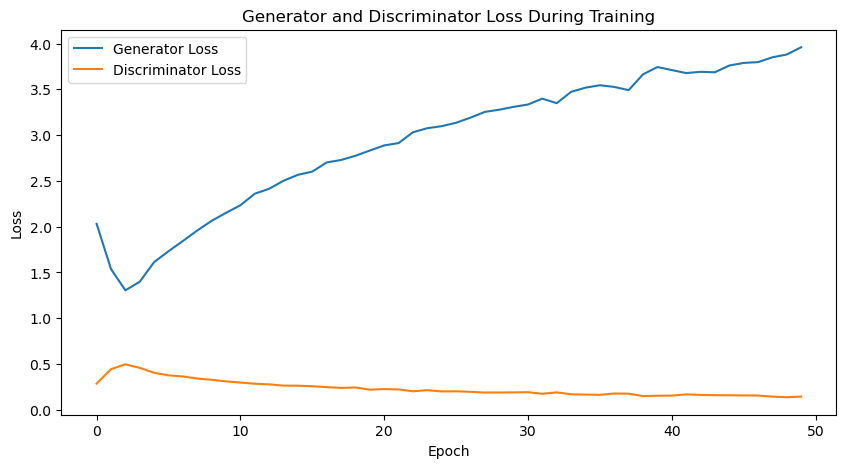

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss_arr, label="Generator Loss")
plt.plot(disc_loss_arr, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

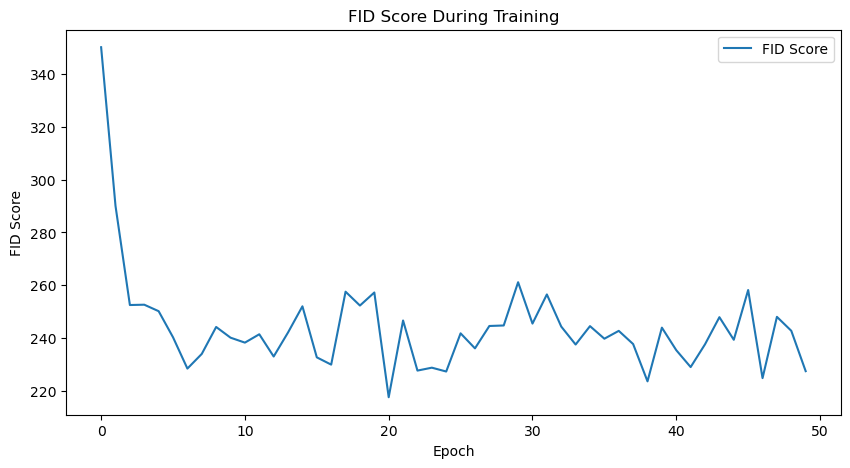

In [19]:
plt.figure(figsize=(10, 5))
plt.title("FID Score During Training")
plt.plot(FID_arr, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

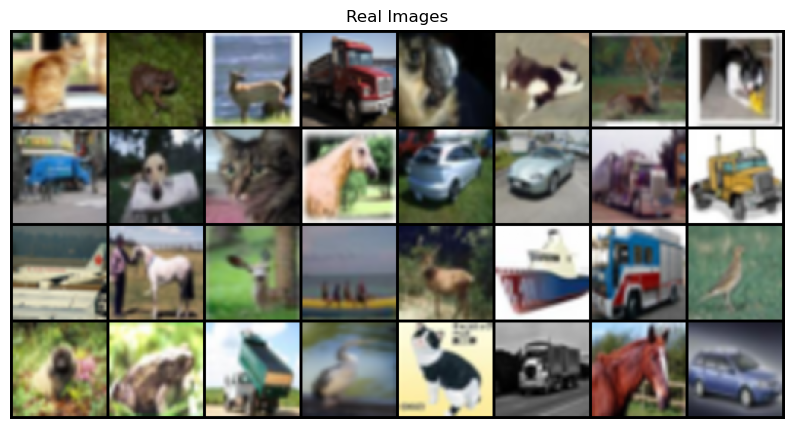

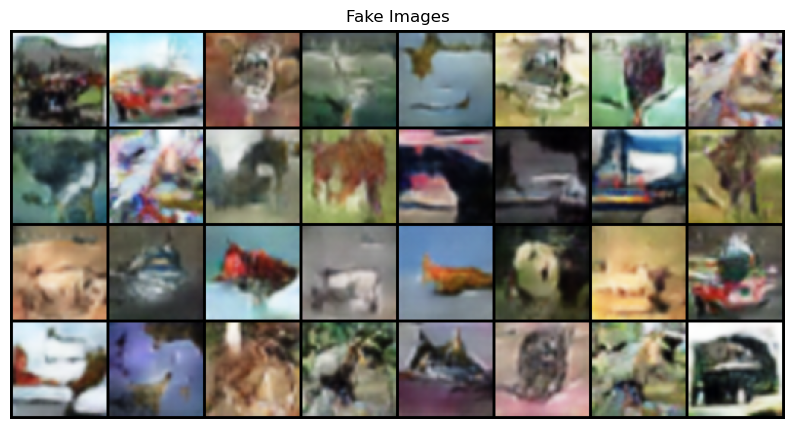

In [20]:
#real
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()


# fake 
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(utils.make_grid(fake_image[-1], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()